#   SENTIMENT ANALYSIS USING LOGISTIC REGRESSION WITH DATA CLEANING AND IMPROVEMENT OF THE FINAL MODEL
## Data processing 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [4]:
num_docs = 5000 #max 25000 

np.random.seed(0) 

#Read the data
df_reviews = pd.read_csv("data/film_data_train.csv")

#Disorder the elements because they are sorted by class
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

#Extract the subset we are going to work with
df_reviews = df_reviews.iloc[:num_docs, :]
df_reviews

,review,sentiment
0,Went to watch this movie expecting a 'nothing ...,0
1,This movie is wonderful. What separates it fro...,1
2,"I guess I've seen worse films, but that may be...",0
3,"If you like CB4, you have no idea what you're ...",1
4,"Expecting to see a ""cute little film"" from mai...",1
...,...,...
4995,This is a good film for 99% of the duration. I...,1
4996,(aka: BLOOD CASTLE or SCREAM OF THE DEMON)<br ...,0
4997,While essentially a remake of the original Chi...,1
4998,From the start I knew I would be in for the be...,1


In [5]:
#Datos de test
df_new_reviews = pd.read_csv("data/film_data_test.csv")

#desordenar los datos
df_new_reviews = df_new_reviews.sample(frac=1).reset_index(drop=True)

# take the set we work with
df_new_reviews = df_new_reviews.iloc[:num_docs,:]

In [6]:
df_reviews.head()

,review,sentiment
0,Went to watch this movie expecting a 'nothing ...,0
1,This movie is wonderful. What separates it fro...,1
2,"I guess I've seen worse films, but that may be...",0
3,"If you like CB4, you have no idea what you're ...",1
4,"Expecting to see a ""cute little film"" from mai...",1


In [13]:
import re

def removeHTML(text):
    #Delete HTML tags
    text = re.sub("<[^>]*>","",text)
    #returns the text
    return text


def clean(text):
    # Save emoticons
    emoticons = re.findall('(?::|;|=)(?:-?)(?:\)|\(|D|P)',text)
    
    # Removes non-alphabetic characters 
    text = re.sub('[\W]+'," ", text.lower())
    text = re.sub('[\d]+',"", text.lower())
    
    #Add the emoticons but remove '-'.
    text = text + " ".join(emoticons).replace('-',"")
    
    # Text back 
    return text 


text = "this is a test to see how the function works.  :-)"
print(clean(text))


this is a test to see how the function works :)


In [ ]:
import nltk 
nltk.download("stopwords") # Download only the first time

stopwords_en = nltk.corpus.stopwords.words("english")  #extract stopwords in English

In [ ]:
from nltk.stem.porter import PorterStemmer #we can do stemming or lemmatisation, in this case we will do stemming.
nltk.download('punkt') # Download only the first time
stemmer = PorterStemmer()

In [11]:
def extracTerms(text):
    #Create the word list
    word_list = [word for word in nltk.word_tokenize(text) if word not in stopwords_en ] 
    
    #Obtains the root of the words
    word_list = [stemmer.stem(word) for word in word_list]
    return word_list

text = "this is a test to see how the function works."

print(extracTerms(text))



['test', 'see', 'function', 'work', '.']


In [14]:
# PROCESSING OF THE DATASET

df_reviews["review"] = df_reviews["review"].apply(removeHTML)
df_reviews["review"] = df_reviews["review"].apply(clean)
df_reviews.head()

,review,sentiment
0,went to watch this movie expecting a nothing r...,0
1,this movie is wonderful what separates it from...,1
2,i guess i ve seen worse films but that may be ...,0
3,if you like cb you have no idea what you re mi...,1
4,expecting to see a cute little film from mainl...,1


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# This tool provides a way to measure importance not only based on frequency, but also taking into account the uniqueness of terms in the dataset.

tfidf_vect = TfidfVectorizer(tokenizer=extracTerms, ngram_range=(1,1))
tfidf_reviews = tfidf_vect.fit_transform(df_reviews["review"].values)

print("The size of the vocabulary is: ", len(tfidf_vect.vocabulary_))

#Create arrays with data (for readability)

X= tfidf_reviews
y = df_reviews["sentiment"].values

El tamaño del vocabulario es:  26340


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25)

## MODEL

In [22]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=10)
lr_model.fit(X_train,y_train)

print("Successful validation: ", lr_model.score(X_train,y_train))
print("Successful test: ", lr_model.score(X_val,y_val))

Successful validation:  0.9984
Successful test:  0.8408


## Improving the model
### Manual search 

In [23]:

c_range = np.logspace(-5,5,11)

best_score = 0 # Mejor resultado
C_b = 0 
for C in c_range:
    lr_model.set_params(C=C)
    lr_model.fit(X_train,y_train)
    train_score, val_score = lr_model.score(X_train, y_train), lr_model.score(X_val, y_val)
    if val_score > best_score:
        best_score = val_score
        C_b = C
    print("Value of C: ", C, "Training: ", train_score, "Validation: ", val_score)
    
print( "The best result is: ",C_b , "with: ", best_score)


Value of C:  1e-05 Training:  0.5056 Validation:  0.4864
Value of C:  0.0001 Training:  0.5056 Validation:  0.4864
Value of C:  0.001 Training:  0.5056 Validation:  0.4864
Value of C:  0.01 Training:  0.8165333333333333 Validation:  0.7456
Value of C:  0.1 Training:  0.8824 Validation:  0.8216
Value of C:  1.0 Training:  0.9549333333333333 Validation:  0.8488
Value of C:  10.0 Training:  0.9984 Validation:  0.8408
Value of C:  100.0 Training:  1.0 Validation:  0.8352
Value of C:  1000.0 Training:  1.0 Validation:  0.8288
Value of C:  10000.0 Training:  1.0 Validation:  0.8304
Value of C:  100000.0 Training:  1.0 Validation:  0.8328
The best result is:  1.0 with:  0.8488


###  Grid Search

In [24]:
from sklearn.model_selection import GridSearchCV

lf_model = GridSearchCV(LogisticRegression(),
                        param_grid={"C":np.logspace(-5,5,11)},
                        cv=5)

lf_model.fit(X,y)

print(lf_model.best_params_)
print(lf_model.best_score_)

{'C': 10.0}
0.8606


# Model validation

In [25]:
from sklearn.model_selection import learning_curve

# sizes
sizes = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# obtains learning curve data
train_sizes,train_scores,test_scores = learning_curve(lr_model,X,y,cv=5, train_sizes=sizes)

#Calculate statistics 
train_scores_mean = np.mean(train_scores,axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [26]:
test_scores

array([[0.788, 0.798, 0.797, 0.788, 0.778],
       [0.818, 0.821, 0.843, 0.836, 0.816],
       [0.826, 0.823, 0.847, 0.823, 0.827],
       [0.846, 0.847, 0.863, 0.845, 0.845],
       [0.85 , 0.849, 0.86 , 0.843, 0.845],
       [0.847, 0.849, 0.868, 0.851, 0.847],
       [0.846, 0.856, 0.875, 0.853, 0.843],
       [0.841, 0.855, 0.873, 0.854, 0.853],
       [0.849, 0.854, 0.866, 0.858, 0.845],
       [0.846, 0.866, 0.871, 0.854, 0.849]])

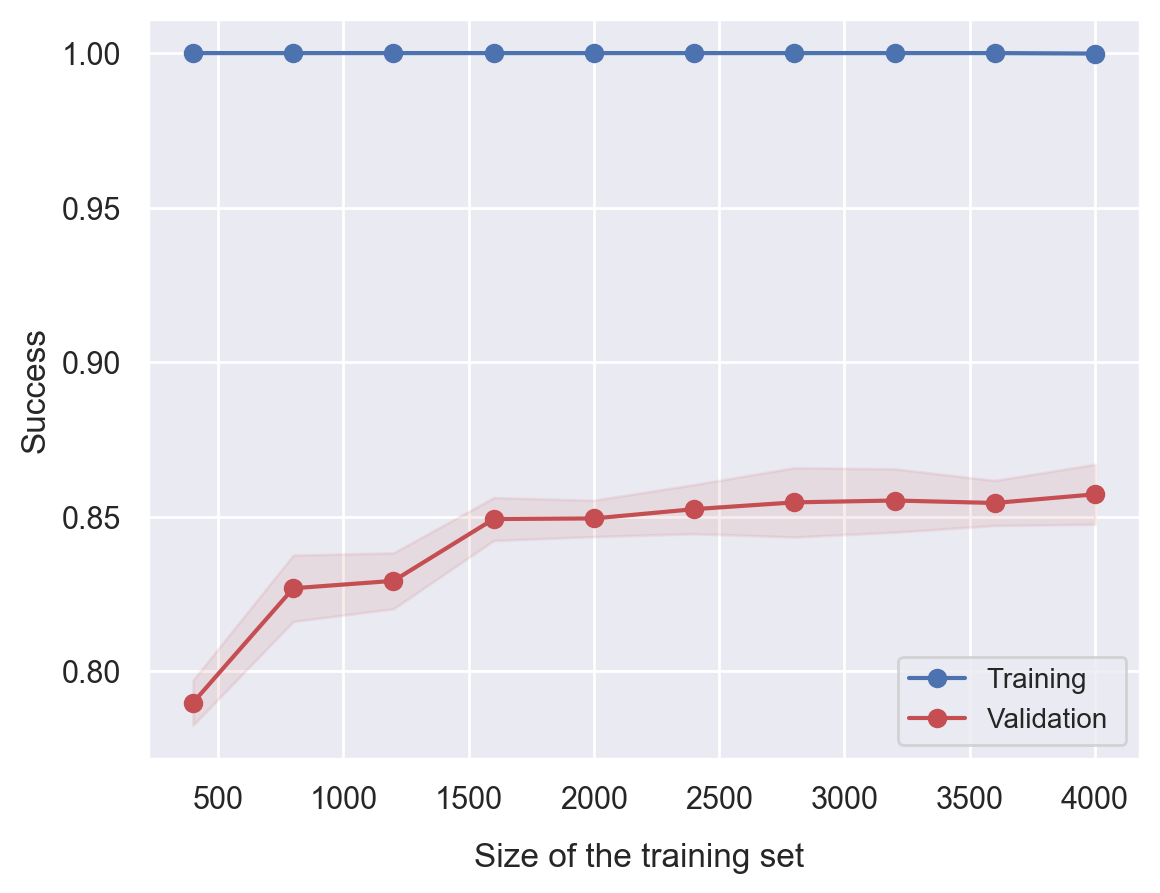

In [27]:
plt.xlabel("Size of the training set ", labelpad=10)
plt.ylabel("Success")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training ")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Validation ")
plt.legend(loc=4, fontsize=10)
plt.show()

## test set new comments 

In [29]:
# We clean the data

df_new_reviews["review"] = df_new_reviews["review"].apply(removeHTML)
df_new_reviews["review"] = df_new_reviews["review"].apply(clean)

#Let's extract the terms  
tfidf_test = tfidf_vect.transform(df_new_reviews["review"])

# we create the training and test suite 
X_test = tfidf_test
y_test = df_new_reviews["sentiment"].values

#classify
print("The hit rate (test) is ", lr_model.score(X_test,y_test))


The hit rate (test) is  0.8394


In [31]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test,y_pred)
# positive and fair comments
prop_real = np.sum(y_test)/len(y_test)
prop_etiquetados = ( (cm[0,1]+cm[1,1]) / len(y_test) )

#We analyse the data
print("Confusion matrix \n\n", cm, "\n")
print("Proportion of positive comments: %.2f" % prop_real)
print("Proportion of positive comments tagged %.2f" % prop_etiquetados)

Confusion matrix 

 [[2086  398]
 [ 405 2111]] 

Proportion of positive comments: 0.50
Proportion of positive comments tagged 0.50


In [32]:
coefficients = lr_model.coef_.ravel()
print("coeficientes: ",coefficients ,"\n")

ord_coefficients = np.argsort(np.abs(coefficients))
print("ord coeficientes: ",ord_coefficients ,"\n")

best_coefficients = ord_coefficients[-50:]
print("best  coeficientes: ",best_coefficients ,"\n")

terms = np.asarray(tfidf_vect.get_feature_names_out())
print("terms: ",terms ,"\n")

relevant_tems = terms[best_coefficients]
print(relevant_tems)

coeficientes:  [ 4.05824986 25.94572041 21.61713053 ...  0.          0.
 -2.4000917 ] 

ord coeficientes:  [11321 11422 15417 ...  9660  1564 25899] 

best  coeficientes:  [18958  7899 26057  7822  1912  7185 24477 17762 11613  5058 18876 22491
 16335  4196 16340  6783 17683  8815 18810  2882 10588 14974 22546 19375
 17759 20859 15191  1893 25492  5705 24395   877 12911 17234 23895  7485
  7317 23102 13703  7986   613  2116  2624 25359 25895  7639  1466  9660
  1564 25899] 

terms:  ['(' ')' ':' ... 'étc' 'ís' 'über'] 

['refresh' 'fantast' 'ye' 'fail' 'becom' 'embarrass' 'unless' 'poorli'
 'instead' 'crap' 'recommend' 'superb' 'often' 'classic' 'oh' 'dull'
 'pointless' 'fun' 'reason' 'brilliant' 'hilari' 'minut' 'suppos'
 'ridicul' 'poor' 'short' 'money' 'beauti' 'well' 'definit' 'unfortun'
 'annoy' 'lack' 'perfect' 'true' 'especi' 'enjoy' 'terribl' 'love'
 'favorit' 'also' 'best' 'bore' 'wast' 'wors' 'excel' 'aw' 'great' 'bad'
 'worst']


# UNIFY EVERYTHING IN ONE PIPELINE

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class Cleaner (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.Series) #We only work with series
        X= X.apply(clean)
        X = X.apply(removeHTML)
        return X

In [36]:
from sklearn.pipeline import Pipeline

# We take the relevant terms from the previous modelling to make a new model based on this model.
new_vocabulary = {}   
for position, word in enumerate(relevant_tems):
    new_vocabulary[word] = position

#creates the new data matrix
tfidf_vect_short = TfidfVectorizer(tokenizer=extracTerms, vocabulary=new_vocabulary)
tfidf_reviews_short = tfidf_vect_short.fit_transform(df_reviews["review"])

# data and classes
X_train_short = tfidf_reviews_short
y_train_short = df_reviews["sentiment"].values 

#create TfidVectorizer object using exctTerms to extract tokens
tfidf_vect = TfidfVectorizer(tokenizer=extracTerms, vocabulary=new_vocabulary)

#create the logistic regression model
lr_model = LogisticRegression(C=1)

#Define el pipeline 
reviews_pipe = Pipeline([
    ("cleaner",Cleaner()),
    ("tfidf", tfidf_vect),
    ("clf", lr_model)
    ])

# We train the model 
reviews_pipe.fit(df_reviews["review"], df_reviews["sentiment"])

print("Training rate (training):  %0.3f" % reviews_pipe.score(df_reviews["review"],df_reviews["sentiment"]))

print("Hit rate (test) %0.3f" % reviews_pipe.score(df_new_reviews["review"],df_new_reviews["sentiment"]))

Training rate (training):  0.813
Hit rate (test) 0.795


## Pipeline + gridsearch

In [37]:
from sklearn.pipeline import Pipeline

#create TfidVectorizer object using exctTerms to extract tokens
tfidf_vect = TfidfVectorizer(tokenizer=extracTerms, vocabulary=new_vocabulary)

#create the logistic regression model
lr_model = LogisticRegression(C=1)

#Define the pipeline 
reviews_pipe = Pipeline([
    ("cleaner",Cleaner()),
    ("tfidf", tfidf_vect),
    ("clf", lr_model)
    ])

#define parameters
parameters = {
    "tfidf__max_features":[1000,5000,10000],
    "tfidf__ngram_range":((1,1), (1,2)), #unigramas o bigramas
    "clf__C":[0.1,1,10]
    
}

grid_search = GridSearchCV(reviews_pipe, parameters, cv=4, n_jobs=-1, verbose=1)

# We train the model 
grid_search.fit(df_reviews["review"], df_reviews["sentiment"])

print("Better parameter settings: ")
best_parameters = reviews_pipe.get_params()
for param in sorted(parameters.keys()):
    print("\t%s: %r" % (param, best_parameters[param]))

# Stores the trained pipeline 
reviews_pipe = grid_search.best_estimator_

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Better parameter settings: 
	clf__C: 1
	tfidf__max_features: None
	tfidf__ngram_range: (1, 1)
